# Figure 3

In Figure 3, we show that its important to determine the phenotypic scale when estimating high-order
epistatic interactions. If we ignore it, we could get spurious high-order epistastic coefficients. For example, if we assume mutations add together (the classical additive epistasis model) when they actually multiply (i.e. a multiplicative scale), we'd need high-order coefficients to explain the variation that arises due to scale. Interpreting these coefficients as actual epistatic interactions would be wrong. They are merely a consequence of missing the scale. Often, the expected phenotypic scale is unknown. We use a power transform to approximate the shape and minimize epistasis.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from epistasis.simulate.linear import LinearSimulation
from epistasis.simulate.nonlinear import NonlinearSimulation
from epistasis import plot
from epistasis.stats import pearson

Construct a linear, high-order genotype-phenotype map.

In [2]:
gpm_linear = LinearSimulation.from_length(5, model_type="global")
gpm_linear.set_coefs_order(5)
gpm_linear.set_coefs_random((-.1,.1))
values = np.array(gpm_linear.epistasis.values)

In [3]:
#### Values that were used in paper
#```python
values = np.array([  5.00000000e-01,   3.34951489e-03,   1.28477614e-01,  
         6.61096956e-02,   1.31881709e-01,   4.33546996e-02, 
         5.30164499e-03,   5.64883892e-04,  -3.79155229e-04,  
        -7.29823966e-03,  -6.95384520e-03,   6.20585012e-03,  
         5.19262442e-03,  -5.85750554e-03,   6.05720340e-03,  
        -7.09030059e-03,   4.52295895e-03,   1.66726657e-03,  
         4.24449352e-03,  -6.34035176e-03,  -4.60532326e-03, 
        -4.23098101e-03,   3.38367575e-03,   6.95966457e-03,
        -4.60099122e-03,   4.35709384e-05,  -9.14285188e-03,
         8.16217118e-03,  -1.35571003e-03,   5.09411701e-03, 
        -7.08329281e-03,   3.06894361e-03])

gpm_linear.epistasis.values = np.array(values)
#```

## Nonlinearity and epistasis show different patterns of variation

We begin by defining a nonlinear relationship to our observable phenotype and an underlying additive phenotype -- a simple saturation model. 
$$
p_{obs} = \frac{(k + 1) \cdot x}{k \cdot x + 1}
$$
We will dope in different "amounts" of nonlinearity by increasing $k$

In [4]:
def saturation(x, k):
    return ((k+1)*x) / (k*x + 1) 

ks = [0,2,4] 

In the first example, we only include additive coefficients to construct the genotype-phenotype map. 
All epistatic coefficients are set to zero.

(<matplotlib.figure.Figure at 0x10a302ac8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10a3772e8>])

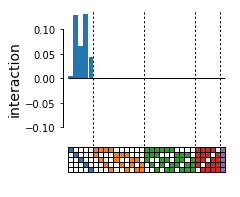

In [5]:
# plot with no epistasis
gpm_linear.epistasis.values[6:] = values[6:] * 0  
gpm_linear.build()

# plot the epistatic coefficient
plot.coefs(gpm_linear.epistasis.values, gpm_linear.epistasis.labels, figsize=(3,3), ybounds=(-.14,.14))

As we dope in nonlinearity to the genotype-phentoype map, patterns that might look like high-order epistasis arises. These coefficients, however, are spurious.

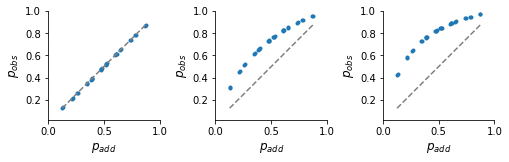

In [6]:
fig = plt.figure(figsize=(8,2))
gs = gridspec.GridSpec(1, 3, wspace=0.5)

# Iterate through different values of k
for i, k in enumerate(ks):
    # Construct a nonlinear space from linear
    gpm_nonlinear = NonlinearSimulation.from_linear(gpm_linear, function=saturation, p0=(k,), model_type="global")
    
    # construct the subplot
    ax = plt.subplot(gs[:, i])
    fig, ax = plot.corr(gpm_linear.p_additive, gpm_nonlinear.phenotypes, fig=fig, ax=ax)
    ax.axis([0,1,0,1.02])
    ax.set_xlabel("$p_{add}$", fontsize=12)
    ax.set_ylabel("$p_{obs}$", fontsize=12)

In the two following spaces, we increase the magnitude of epistasis and watch the $P_{obs}$ vs. $P_{add}$ curves.

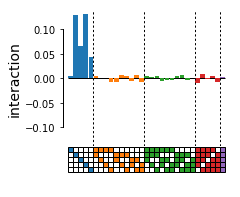

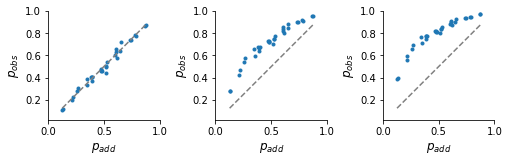

In [7]:
#### increase the high-order epistasis
gpm_linear.epistasis.values[6:] = values[6:] * 1 
gpm_linear.build()

# plot the epistatic coefficient
fig, ax = plot.coefs(gpm_linear.epistasis.values, gpm_linear.epistasis.labels, figsize=(3,3), ybounds=(-.14,.14))

#### Dope in nonlinear epistasis!
fig = plt.figure(figsize=(8,2))
gs = gridspec.GridSpec(1, 3, wspace=0.5)

# Iterate through different values of k
for i, k in enumerate(ks):
    # Construct a nonlinear space from linear
    gpm_nonlinear = NonlinearSimulation.from_linear(gpm_linear, function=saturation, p0=(k,), model_type="global")
    
    # construct the subplot
    ax = plt.subplot(gs[:, i])
    fig, ax = plot.corr(gpm_linear.p_additive, gpm_nonlinear.phenotypes, fig=fig, ax=ax)
    ax.axis([0,1,0,1.02])
    ax.set_xlabel("$p_{add}$", fontsize=12)
    ax.set_ylabel("$p_{obs}$", fontsize=12)

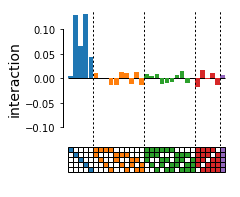

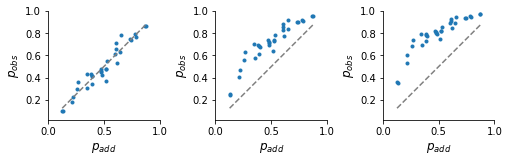

In [8]:
# increase the high-order epistasis
gpm_linear.epistasis.values[6:] = values[6:] * 2  
gpm_linear.build()

# plot the epistatic coefficient
plot.coefs(gpm_linear.epistasis.values, gpm_linear.epistasis.labels, figsize=(3,3), ybounds=(-.14,.14))

fig = plt.figure(figsize=(8,2))
gs = gridspec.GridSpec(1, 3, wspace=0.5)

# Iterate through different values of k
for i, k in enumerate(ks):
    # Construct a nonlinear space from linear
    gpm_nonlinear = NonlinearSimulation.from_linear(gpm_linear, function=saturation, p0=(k,), model_type="global")
    
    # construct the subplot
    ax = plt.subplot(gs[:, i])
    fig, ax = plot.corr(gpm_linear.p_additive, gpm_nonlinear.phenotypes, fig=fig, ax=ax)
    ax.axis([0,1,0,1.02])
    ax.set_xlabel("$p_{add}$", fontsize=12)
    ax.set_ylabel("$p_{obs}$", fontsize=12)

## Fit a nonlinear genotype-phenotype map with a nonlinear least squares epistasis regression.

In [9]:
from epistasis.models.nonlinear.power import EpistasisPowerTransform
from epistasis.models.linear.regression import EpistasisLinearRegression

Now, let's fit a nonlinear-genotype-phenotype map with a nonlinear high-order epistasis model. We will use the same map as the examples above, with $1 \times$ the epistasis, and $k=2$

In [40]:
# Reinit our linear epistasis map with 
gpm_linear.epistasis.values[6:] = values[6:] * 1
gpm_linear.build()

# Dope in nonlinearity
k = 2
gpm_nonlinear = NonlinearSimulation.from_linear(gpm_linear, function=saturation, p0=(k,), model_type="global")

If we fit the genotype-phenotype map with a linear epistasis model, ignoring the scale, we get spurious epistatic coefficients.

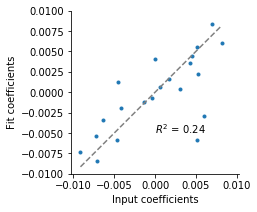

In [82]:
model_coefs = EpistasisLinearRegression.from_gpm(gpm_nonlinear, order=5, model_type="global")
model_coefs.fit()

known = gpm_linear.epistasis.values[6:]
fit = model_coefs.epistasis.values[6:]
fig, ax1 = plot.corr(known, fit, figsize=(3,3))
ax1.axis([-.01,.01,-.01,.01])
rsquared = "$R^2$ = " + str(round(pearson(known, fit)**2, 2))
ax1.annotate(rsquared, xy=(0, -.005))
ax1.set_xlabel("Input coefficients")
ax1.set_ylabel("Fit coefficients")

Now, we'll use a power transform the back out the phenotypic scale.

r-squared: 0.984762364204
Parameter values: {'lmbda': 0.43989787284372744, 'A': -0.38744248263412878, 'B': 1.1599631942041704}


/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:314: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
/Users/Zsailer/Documents/Research/projects/pkgs/epistasis/epistasis/models/nonlinear/power.py:12: RuntimeWarning: invalid value encountered in power
  first = (x+A)**lmbda


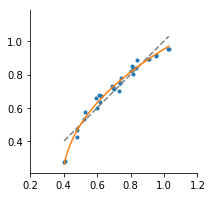

In [84]:
model_nonlinear = EpistasisPowerTransform.from_gpm(gpm_nonlinear, order=1, fix_linear=True, model_type="global")
model_nonlinear.fit(lmbda=2, A=1, B=1) # arguments are initial guess.
print("r-squared: " + str(model_nonlinear.score()))
print("Parameter values: " + str(model_nonlinear.parameters()))

padd = model_nonlinear.predict_linear()
pobs = model_nonlinear.gpm.phenotypes
fig, ax = plot.corr(padd, pobs, figsize=(3,3))
xmodel = np.linspace(min(padd), max(padd), 1000)
ymodel = model_nonlinear.function(xmodel, *model_nonlinear.parameters.get_params())
ax.plot(xmodel, ymodel, '-')
z = ax.axis([.2,1.2,.2,1.2])

In [85]:
linear_phenotypes = model_nonlinear.transform_target()
model_coefs = EpistasisLinearRegression.from_data(
    gpm_nonlinear.wildtype,
    gpm_nonlinear.genotypes,
    linear_phenotypes,
    order=5,
    model_type="global"
)
model_coefs.fit()

## How did we do?

Let's look at the correlation between the input coefficients and our model's coefficients -- **much improved!**

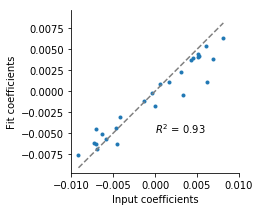

In [86]:
known = gpm_linear.epistasis.values[6:]
fit = model_coefs.epistasis.values[6:]
fig, ax1 = plot.corr(known, fit, figsize=(3,3))
ax1.axis([-.01,.01,-.01,.01])
rsquared = "$R^2$ = " + str(round(pearson(known, fit)**2, 2))
ax1.annotate(rsquared, xy=(0, -.005))
ax1.set_xlabel("Input coefficients")
ax1.set_ylabel("Fit coefficients")